In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import sys
#sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')
path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0, path_to_mavenn)

# import mavenn
import mavenn

In [2]:
# Load GB1 MAVE-NN models
model = mavenn.load('gb1_additive_ge_2021.12.28.17h.21m')
sim_model = mavenn.load('gb1_ge_sim')

Model loaded from these files:
	gb1_additive_ge_2021.12.28.17h.21m.pickle
	gb1_additive_ge_2021.12.28.17h.21m.h5
Model loaded from these files:
	gb1_ge_sim.pickle
	gb1_ge_sim.h5


In [3]:
# load data to compare ground-truth model
# Load example data (WHICH CONTAINS DOUBLE MUTANTS ONLY!)
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')

# load data to compare ground-truth model
x_test = test_df['x'].values
y_test = test_df['y'].values
phi_test = model.x_to_phi(x_test)
yhat_test = model.x_to_yhat(x_test)
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)

test N: 26,364
training + validation N: 504,373


In [4]:
# get pairwise theta from model trained on experimental data
theta_lc = model.get_theta()['theta_lc']
# drop nans to plotting
theta_lc = theta_lc[~np.isnan(theta_lc)]

In [5]:
sim_theta_lc = sim_model.get_theta()['theta_lc']
sim_theta_lc = sim_theta_lc[~np.isnan(sim_theta_lc)]

In [6]:
# load model training times and Rsq for each simulated dataset size.
training_times = []
model_Rsqs = []
#data_sizes = [1000,3000,1000,10000,30000,100000,300000,1000000]
data_sizes = [1000,3000,10000,30000,100000,300000]
for data_size in data_sizes:
    training_times.append(np.loadtxt(f'models/N_{data_size}/training_times.txt'))
    model_Rsqs.append(np.loadtxt(f'models/N_{data_size}/model_Rsqs.txt'))

In [7]:
model_Rsqs[0]

array([0.54603507, 0.4213386 , 0.5356635 , 0.52454434, 0.46001626,
       0.5633028 , 0.4909573 , 0.49870589, 0.50240569, 0.5628473 ])

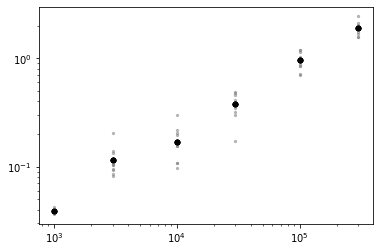

In [8]:
for model_index in range(len(data_sizes)):
    
    mean = np.mean(training_times[model_index])
    for time in training_times[model_index]:
        #print(time)
        plt.scatter(data_sizes[model_index],time/60,s=5,color='gray',alpha=0.5)
        plt.scatter(data_sizes[model_index],mean/60,s=20,color='black',alpha=1)        

plt.xscale('log')    
plt.yscale('log') 
plt.show()

In [9]:
# Predict latent phentoype values (phi) on test data
sim_phi_test = sim_model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
sim_yhat_test = sim_model.x_to_yhat(x_test)

In [10]:
def estimate_Rsq_error_from_boostrap(data_array_1,
                                     data_array_2,
                                     number_of_bs_trials=1000):

    number_data = data_array_1.shape[0]

    Rsq_bs = np.zeros(shape=number_of_bs_trials)
    size_of_drawn_samples = int(number_data*0.25)

    for trial in range(number_of_bs_trials):

        # sample quarter of the data with replacement
        ix = np.random.choice(number_data, size=size_of_drawn_samples, replace=True)

        # compute individual R values for the current bs sample
        R_sq_sub = np.corrcoef(data_array_1[ix], data_array_2[ix])[0][1]**2        
        Rsq_bs[trial] = R_sq_sub
        
    std_error = np.std(Rsq_bs)
    return std_error 

In [11]:
f'{estimate_Rsq_error_from_boostrap(sim_yhat_test, yhat_test):.3e}'

'1.034e-05'

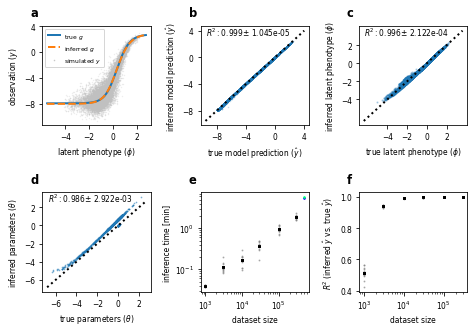

In [12]:
fig, ax = plt.subplots(2, 3, figsize=[6.69291,4.75])

subpanel_letter_pos_x = -0.11
subpanel_letter_pos_y = 1.1

# Compute yhat each phi gridpoint
sim_yhat_grid = sim_model.phi_to_yhat(phi_grid)

ax[0,0].plot(phi_grid,yhat_grid, lw=2, label='true $g$')
ax[0,0].plot(phi_grid,sim_yhat_grid, linestyle='--',lw=2, label='inferred $g$')
ax[0,0].scatter(sim_phi_test, y_test, color='silver', s=0.25, alpha=0.25, label ='simulated $y$')

ax[0,0].set_xlabel('latent phenotype ($\phi$)',fontsize=7.5)
leg = ax[0,0].legend(fontsize=7,prop={'size': 6}, loc='upper left')

for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax[0,0].set_ylabel('observation ($y$)',fontsize=7.5)
ax[0,0].tick_params(labelsize=7.5)
ax[0,0].text(subpanel_letter_pos_x, subpanel_letter_pos_y, 'a',fontsize=11.5, fontweight='bold',transform=ax[0,0].transAxes)
ax[0,0].set_xticks([-4,-2,0,2])
ax[0,0].set_yticks([-8,-4,0,4])

Rsq_sim = np.corrcoef(sim_yhat_test, yhat_test)[0][1]**2
ax[0,1].scatter(sim_yhat_test,yhat_test,s=0.25,alpha=0.25)
lims = list(ax[0,1].get_xlim())
lims[0]-=1
lims[1]+=1
ax[0,1].plot(lims, lims, linestyle=':', color='k', label='$y=\hat{y}$', lw=2)

delta_Rsq_sim = f'{estimate_Rsq_error_from_boostrap(sim_yhat_test, yhat_test):.3e}'

ax[0,1].text(0.05,0.9,'$R^2: $'+str(Rsq_sim)[0:5]+'$\pm$ '+delta_Rsq_sim, fontsize=7.5, fontweight='regular',transform=ax[0,1].transAxes)

ax[0,1].set_xlabel('true model prediction ($\hat{y}$)',fontsize=7.5)
ax[0,1].set_ylabel('inferred model prediction ($\hat{y}$)',fontsize=7.5)
ax[0,1].tick_params(labelsize=7.5)
ax[0,1].set_xticks([-8,-4,0,4])
ax[0,1].set_yticks([-8,-4,0,4])

ax[0,1].text(subpanel_letter_pos_x, subpanel_letter_pos_y, 'b',fontsize=11.5, fontweight='bold',transform=ax[0,1].transAxes)

Rsq_phi_sim = np.corrcoef(phi_test, sim_phi_test)[0][1]**2
delta_Rsq_phi_sim = f'{estimate_Rsq_error_from_boostrap(phi_test, sim_phi_test):.3e}'

ax[0,2].scatter(phi_test,sim_phi_test,s=1.5,alpha=0.25)
lims = list(ax[0,2].get_xlim())
lims[0]-=1
lims[1]+=1
ax[0,2].plot(lims, lims, linestyle=':', color='k', lw=2)
ax[0,2].text(0.05, 0.9,'$R^2: $'+str(Rsq_phi_sim)[0:5]+'$\pm$ '+delta_Rsq_phi_sim, fontsize=7.5, fontweight='regular',transform=ax[0,2].transAxes)
ax[0,2].set_ylabel('inferred latent phenotype ($\phi$)', fontsize=7.5)
ax[0,2].set_xlabel('true latent phenotype ($\phi$)', fontsize=7.5)
ax[0,2].text(subpanel_letter_pos_x, subpanel_letter_pos_y, 'c',fontsize=11.5, fontweight='bold',transform=ax[0,2].transAxes)
ax[0,2].tick_params(labelsize=7.5)
ax[0,2].set_xticks([-4,-2,0,2])
ax[0,2].set_yticks([-4,-2,0,2])

Rsq_theta_sim = np.corrcoef(theta_lc, sim_theta_lc)[0][1]**2
delta_Rsq_theta_sim = f'{estimate_Rsq_error_from_boostrap(theta_lc, sim_theta_lc):.3e}'

ax[1,0].scatter(theta_lc,sim_theta_lc,s=0.5,alpha=0.5)
lims = ax[1,0].get_xlim()
ax[1,0].plot(lims, lims, linestyle=':', color='k', lw=2)
#ax[1,0].text(-0.75, 0.8,'$R^2: $'+str(Rsq_theta_sim)[0:5])
ax[1,0].text(0.05, 0.9,'$R^2: $'+str(Rsq_theta_sim)[0:5]+'$\pm$ '+delta_Rsq_theta_sim, fontsize=7.5, fontweight='regular',transform=ax[1,0].transAxes)
ax[1,0].text(subpanel_letter_pos_x, subpanel_letter_pos_y, 'd',fontsize=11.5, fontweight='bold',transform=ax[1,0].transAxes)
ax[1,0].set_ylabel('inferred parameters (${\\theta}$)',fontsize=7.5)
ax[1,0].set_xlabel('true parameters (${\\theta}$)',fontsize=7.5)
ax[1,0].tick_params(labelsize=7.5)
ax[1,0].set_yticks([-6,-4,-2,0,2])
ax[1,0].set_xticks([-6,-4,-2,0,2])

for model_index in range(len(data_sizes)):
    
    mean = np.mean(training_times[model_index])
    for time in training_times[model_index]:
        #print(time)
        ax[1,1].scatter(data_sizes[model_index],time/60,s=1,color='gray',alpha=0.5)
        ax[1,1].scatter(data_sizes[model_index],mean/60,s=3,color='black',alpha=1)        

ax[1,1].scatter([len(data_df)],[320.6/60],color='blue',s=2.5)
ax[1,1].scatter([len(data_df)],[348.4/60],color='springgreen',s=2.5,zorder=2) # bootstrap model time
ax[1,1].set_xscale('log')    
ax[1,1].set_yscale('log') 
ax[1,1].text(subpanel_letter_pos_x, subpanel_letter_pos_y, 'e',fontsize=11.5, fontweight='bold',transform=ax[1,1].transAxes)
ax[1,1].set_xlabel('dataset size',fontsize=7.5)
ax[1,1].set_ylabel('inference time [min]',fontsize=7.5)
ax[1,1].tick_params(labelsize=7.5)
ax[1,1].set_xticks([1e3,1e4,1e5])

for model_index in range(len(data_sizes)):
    
    mean = np.mean(model_Rsqs[model_index])
    for rsq in model_Rsqs[model_index]:
        #print(time)
        ax[1,2].scatter(data_sizes[model_index],rsq,s=1,color='gray',alpha=0.5)
        ax[1,2].scatter(data_sizes[model_index],mean,s=3,color='black',alpha=1)        

ax[1,2].set_xscale('log')    
#ax[1,2].set_yscale('log') 
ax[1,2].set_xlabel('dataset size',fontsize=7.5)
ax[1,2].set_ylabel('$R^2$ (inferred $\hat{y}$ vs. true $\hat{y}$)',fontsize=7.5)
ax[1,2].text(subpanel_letter_pos_x, subpanel_letter_pos_y, 'f',fontsize=11.5, fontweight='bold',transform=ax[1,2].transAxes)
ax[1,2].tick_params(labelsize=7.5)
ax[1,2].set_xticks([1e3,1e4,1e5])

plt.tight_layout()
fig.savefig('Figure_S1_GB1.png', dpi=300,bbox_inches='tight')